In [1]:
# Import libraries
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

In [2]:
# Import data
input_listings = './data/seattle/listings.csv'
input_reviews = './data/seattle/reviews.csv'
input_calendar = './data/seattle/calendar.csv'

calendar = pd.read_csv(input_calendar)
listings = pd.read_csv(input_listings)
reviews = pd.read_csv(input_reviews)

### Utils functions

This section contains the functions which are used in this notebook.

In [3]:
def convert2float(numeric_in_string):
    '''
    Converts a number in string to float
    :param numeric_in_string: number in string
    :return: number in float
    '''
    if pd.isna(numeric_in_string):
        p = numeric_in_string
    else:
        p = float(numeric_in_string.strip("$").replace(',', ''))
    return p

In [4]:
def create_dummy_df(df, cat_cols):
    '''
    Creates dummies for categorical variables, drop the categorical variable columns, and create
    a concatenate dataframe for numeric and categorical variables
    :param df: a dataframe containing numeric variables and categorical variables
    :param cat_cols: a list of categorical variables
    :return: a concatenated dataframe with numeric variables and dummies variables
    '''
    for col in cat_cols:
        if isinstance(df[col][0], str):
            cat_df = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=True)
            df = df.drop(col, axis=1)
            combined_df = pd.concat([df, cat_df], axis=1)
            return combined_df
        elif isinstance(df[col][0], list):
            cat_df = df[col].str.join(sep='*').str.get_dummies(sep='*')
            df = df.drop(col, axis=1)
            combined_df = pd.concat([df, cat_df], axis=1)
            return combined_df

In [5]:
def create_linear_model(df, response_col, test_size):
    '''
    Defines predicting variables from dataframe as X, target variable as y. Split X, y into
    training set, test set based on test_size. Standardised the scale in features. Instantiates a linear
    regression model, fits the model to training set, predicts the output of X_test, X_train. Lastly,
    calculates the r2 scores
    :param df: dataframe containing predicting variables and target variable
    :param response_col: the target variable
    :param test_size: size of test set
    :return: r2score for train set, test set
    '''
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.pipeline import make_pipeline
    from sklearn.metrics import r2_score

    X = df.drop(response_col, axis=1).values
    y = df[response_col].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=420)
    lm_model = make_pipeline(StandardScaler(with_std=False), LinearRegression())
    lm_model.fit(X_train, y_train)

    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score

In [6]:
def extract_amenities(df, amenities_col, common_amenities_col, topN_Items):
    '''
    Extracts amenities (TV, Internet, etc...) from the amenities column in a given dataframe.
    :param df: pricePredictDF dataframe
    :param amenities_col: the 'amenities' column
    :param common_amenities_col: the common_amenities column
    :return: pricePredictDF dataframe
    '''
    # extract amenities
    amenitiesCandidates = extract_amenities_candidates(df, amenities_col)

    # find the most common amenities
    amenities_list = find_common_items(amenitiesCandidates, topN_Items)

    df[common_amenities_col] = find_matching_amenities(df, common_amenities_col, amenities_list)
    return df

In [7]:
def convert_string_to_list(df_row):
    '''
    Replaces punctuations in string and converts the string to list
    :param df_row: string on each row in given dataframe
    :return: a list of string
    '''
    amenitiesCandidates = df_row.replace('"', '').replace("{", "").replace("}", "").replace("''", "")
    amenitiesCandidates = amenitiesCandidates.split(",")
    return amenitiesCandidates

In [8]:
def find_matching_amenities(df, original_col, common_amenities_list):
    '''
    Compares the original amenities col to the common amenities list. It returns a list of
    matching amenities for each row
    :param df: pricePredictDF dataframe
    :param original_col: 'amenities' col in pricePredictDF dataframe
    :param common_amenities_list: common amenities list
    :return: matching list of amenities for each row
    '''
    amenitieslist = []

    for original_list in df[original_col]:
        amenitiesPerRow = []
        for ele in original_list:
            if ele in common_amenities_list:
                amenitiesPerRow.append(ele)
        amenitieslist.append(amenitiesPerRow)
    return amenitieslist

In [9]:
def extract_amenities_candidates(df, amenities_col):
    '''
    Extracts amenities for each row from amenities column in a given dataframe, extend them to a list
    of amenities.
    :param df: pricePredictDF dataframe
    :param amenities_col: amenities column from pricePredictDF dataframe
    :return: a list of all amenities candidates
    '''
    rowCandidatesSum = []
    for row in df[amenities_col]:
        rowCandidates = convert_string_to_list(row)
        rowCandidatesSum.extend(rowCandidates)
    return rowCandidatesSum

In [10]:
def find_common_items(items_list, topN_Items):
    '''
    Finds common items in an item list
    :param items_list: a list of items
    :param topN_Items: Number of common items
    :return: a list of common items
    '''
    import collections

    commonItemsList = []
    counter = collections.Counter(items_list)
    for name, count in counter.most_common(n=topN_Items):
        commonItemsList.append(name)
    return commonItemsList

In [11]:
def subset_dataset(df, subset_col, criteria):
    '''
    Subsets the dataframe which equals the criteria value of the subset_col
    :param df: the listings dataframe
    :param subset_col: the column for subset
    :param criteria: subset criteria. it's a value in the subset_col
    :return: a subset dataframe meeting the criteria
    '''

    subset_option = df.loc[df[subset_col] == criteria]
    return subset_option


def clean_text(df_row, stopwords_list):
    '''
    Cleans the text on a row in a dataframe
    :param df_row: the text row in a dataframe
    :param stopwords_list: a list of words to be removed
    :return: the clean text row
    '''
    import re

    if not pd.isna(df_row):
        # remove punctuation
        output_str = re.sub(r'[^\w]+(\s+|$)', ' ', df_row).strip()
        output_str = output_str.replace('"', '')

        # remove stopwords
        filtered_words = remove_stopwords(output_str, stopwords_list)
        lemmatized_words = lemmatize_text(filtered_words)
        output_str = ' '.join(lemmatized_words)

        return output_str
    else:
        output_str = " "
        df_row = output_str
        return df_row


def remove_stopwords(df_row, stopwords_list):
    '''
    Removes common stopwords from the text row in a dataframe
    :param df_row: the text row in a dataframe
    :param stopwords_list: a list of words to be removed
    :return: text row without common stopwords
    '''
    from nltk.corpus import stopwords

    word_list = df_row.lower().split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    filtered_words = [word for word in filtered_words if word not in stopwords_list]
    return filtered_words


def lemmatize_text(filtered_words_list):
    from nltk.stem import WordNetLemmatizer

    lemmatized_words = []

    lemmatizer = WordNetLemmatizer()

    for word in filtered_words_list:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemmatized_word)
    return lemmatized_words


def create_wordcloud(df, text_col):
    '''
    Creates a wordcloud to populate the common words in the text_col
    :param df: a dataframe
    :param text_col: a text column for finding common words
    :return: a wordcloud
    '''
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt

    text = " ".join(review for review in df[text_col])

    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["neighborhood", "seattle", "belltown", "pike", "place", "many", "N", "great", "walk", "close",
                      "lot", "minute", "block", "junction", "walking", "distance", "home", "lock", "good", "best",
                      "lower", "located", "mile", "top", "house", "away", "one", "volunteer", "away", "house",
                      "center", "nearby", "within", "view", "well", "everything", "street", "take"])

    # Generate a word cloud image
    wordcloud = WordCloud(collocations=True, stopwords=stopwords, background_color="white").generate(text)
    print("wordcloud words:", wordcloud.words_)

    # Display the generated image
    plt.figure(figsize=(14, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### EDA / Assess Data

###	Q1 - What are the busiest times of the year to visit Seattle?

### Data Preparation

In [12]:
# get the year and month
calendar['year'] = pd.DatetimeIndex(calendar['date']).year
calendar['month'] = pd.DatetimeIndex(calendar['date']).month

# Since there is incomplete data in 2017, remove these rows to minimise the bias
calendar = calendar[calendar['year'] < 2017]

In [13]:
# Remove $ sign from price and convert price in str to float
calendar['price'] = calendar['price'].apply(lambda x:utils.convert2float(x))

### Availability distribution

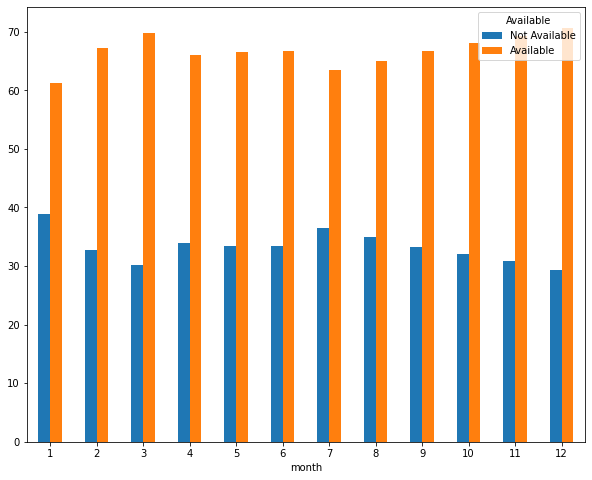

In [14]:
# plot airBnB availability
ax = pd.crosstab(calendar['month'], calendar['available']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,8), stacked=False, rot=0)
L = plt.legend(loc='upper right', title="Available")
L.get_texts()[0].set_text('Not Available')
L.get_texts()[1].set_text('Available')
plt.show()

### Insights
The busiest time to visit Seattle is January. January has the least amount of available rental properties on AirBnB. 

### Q2. By how much do prices spike?

In [ ]:
# Calculate the mean price per month
calendar_available_price_grouped = calendar_available.groupby(by=['month'])['price'].mean().reset_index()
# calendar_available_price_grouped

In [ ]:
# plot the price line chart
plt.figure(figsize=(12,8))

plt.plot(calendar_available_price_grouped['month'], calendar_available_price_grouped['price'], marker='o')
plt.title("Price fluctuations over months")
plt.xlabel("Month")
plt.ylabel("Price")
plt.grid(True)
plt.show()

### Insights
The highest price is at July. About 60% of the properties were rented out. The lowest price was in Janaury, resulted in about 70% of properties were rented out. The price growth was pretty steady from January to the peak in July; the price then declined gradually and increased a bit again for December.

In [ ]:
priceSpikePercent = round((calendar_available_price_grouped.iloc[6,1] - calendar_available_price_grouped.iloc[0,1])/calendar_available_price_grouped.iloc[0,1] * 100, 2)
print("The price in July was about {}% higher than the price in Jan".format(priceSpikePercent))

### TODO - How to adjust the price to ensure each proerty would be rented out every month?

### Q3 - What features predict Price

#### Data Cleaning

In [ ]:
pricePredictDF = listings[['neighbourhood_group_cleansed', 'property_type', 'accommodates', 'bathrooms', 'bedrooms',
                           'beds', 
                           'review_scores_rating',
                           'amenities', 
                           'cleaning_fee', 
                           'price']]

In [ ]:
# Convert cleaning fee column to float
pricePredictDF['cleaning_fee_float'] = pricePredictDF['cleaning_fee'].apply(lambda x: utils.convert2float(x))

# Remove the row with missing property type
pricePredictDF = pricePredictDF.dropna(subset=['property_type'])

# Convert price column to float
pricePredictDF['price'] = pricePredictDF['price'].apply(lambda x:utils.convert2float(x))

In [ ]:
# check correlation for numeric vars
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_vars_df = pricePredictDF.select_dtypes(include=numerics)

numeric_vars_df.corr()

<code>accommodates</code> has a very strong relationship with <code>bedrooms</code> and <code>beds</code>. And <code>accommodates</code> has the strongest relationship with <code>price</code>. Let's keep <code>accommodates</code>.<br>
<code>review_scores_rating</code> has a weak relationship with <code>price</code>. Let's remove it too.
<br>

In [ ]:
pricePredictDF = pricePredictDF[[
                                 'neighbourhood_group_cleansed', 
                                 'property_type', 
                                 'bathrooms', 
                                 'accommodates', 
#                                  'review_scores_rating',
                                 'amenities', 
                                 'cleaning_fee_float',
                                 'price']]

In [ ]:
# handling missing values
pricePredictDF['bathrooms'] = pricePredictDF['bathrooms'].fillna(pricePredictDF['bathrooms'].median())
# pricePredictDF['bedrooms'] = pricePredictDF['bedrooms'].fillna(pricePredictDF['bedrooms'].median())
# pricePredictDF['beds'] = pricePredictDF['beds'].fillna(pricePredictDF['beds'].median())
# pricePredictDF['review_scores_rating'] = pricePredictDF['review_scores_rating'].fillna(pricePredictDF['review_scores_rating'].median())
pricePredictDF['cleaning_fee_float'] = pricePredictDF['cleaning_fee_float'].fillna(pricePredictDF['cleaning_fee_float'].median())

In [ ]:
# Extract Common Amenities to list
pricePredictDF['amenities'][0]

pricePredictDF['common_amenities'] = pricePredictDF['amenities'].apply(lambda x: utils.convert_string_to_list(x))
pricePredictDF = utils.extract_amenities(pricePredictDF, 'amenities', 'common_amenities', 15)

In [ ]:
# create dummy for categorical variables
pricePredictDF = utils.create_dummy_df(pricePredictDF, ['property_type'])
pricePredictDF = utils.create_dummy_df(pricePredictDF, ['neighbourhood_group_cleansed'])
pricePredictDF = utils.create_dummy_df(pricePredictDF, ['common_amenities'])
pricePredictDF = pricePredictDF.drop('amenities', axis=1)

In [ ]:
pricePredictDF.columns

In [ ]:
test_score, train_score = utils.create_linear_model(pricePredictDF, 'price', 0.2)

In [ ]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

### Q4 - Can you describe the vibe of each Seattle neighborhood using listing descriptions?

In [ ]:
seattleTowns = listings['neighbourhood_group_cleansed'].unique().tolist()  
seattleTowns = [town.lower().split() for town in seattleTowns]

seattleTowns_flat = [item for sublist in seattleTowns for item in sublist]

In [ ]:
listings['neighborhood_overview_cleaned'] = listings['neighborhood_overview'].apply(lambda x: utils.clean_text(x, seattleTowns_flat))

In [ ]:
downtown = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Downtown')
capitolHill = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Capitol Hill')
queenAnne = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Queen Anne')
ballard = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Ballard')
weatSeattle = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'West Seattle')
northgate = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Northgate')
beaconHill = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Beacon Hill')

In [ ]:
# downtown
utils.create_wordcloud(downtown, 'neighborhood_overview_cleaned')

In [ ]:
# capitol hill
utils.create_wordcloud(capitolHill, 'neighborhood_overview_cleaned')

In [ ]:
# queen anne
utils.create_wordcloud(queenAnne, 'neighborhood_overview_cleaned')

In [ ]:
# ballard
utils.create_wordcloud(ballard, 'neighborhood_overview_cleaned')

In [ ]:
# west seattle
utils.create_wordcloud(weatSeattle, 'neighborhood_overview_cleaned')

In [ ]:
# north gate
utils.create_wordcloud(northgate, 'neighborhood_overview_cleaned')

In [ ]:
# beacon hill
utils.create_wordcloud(beaconHill, 'neighborhood_overview_cleaned')

### Q3 - negative and positive reviews